# ImgLib2 

Example 06a:  Gaussian convolution

**Note:** ImgLib2 contains a growing number of built-in standard algorithms. In examples 06a, 06b, and 06c, we will show some of those, illustrate how to use them and give some examples of what they might be used for.

Typically algorithms provide static methods for simple calling, but they also have classes which you can instantiate yourself to have more options.

*Important: Algorithms do not allow to work on a different dimensionality than the input data. You can achieve that by selecting hyperslices using [Views](http://javadoc.imagej.net/ImgLib2/net/imglib2/view/Views.html) (see Example 6a - variation 4). In this way, you can for example apply two-dimensional gaussians to each frame of a movie independently.*

## Introduction

The Gaussian convolution has its own [wiki](http://imagej.net/Gauss_Package_ImgLib2) page. You can apply the Gaussian convolution with different sigmas in any dimension. It will work on any kind of [**RandomAccessibleInterval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessibleInterval.html). Below we show examples of a simple gaussian convolution (variation 1), convolution using a different [**OutOfBoundsStrategy**](http://javadoc.imagej.net/ImgLib2/net/imglib2/view/Views.html) (variation 2), convolution of a part of an [**Interval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html) (variation 3), and convolution of in a lower dimensionality than the image data (variation 4).

## Bootstrap ImageJ

In [1]:
// @ImageJ ij
// @NotebookService nb

// Behind a firewall? Configure your proxy settings here.
//systemProperties = System.getProperties()
//systemProperties.setProperty("http.proxyHost","myproxy.domain")
//systemProperties.setProperty("http.proxyPort","8080")

//////////////////////////////////////////////////////////////
// Load ImageJ. This may take some minutes the first time   //
// while ImageJ is installed into ~/.groovy/grapes locally. //
//////////////////////////////////////////////////////////////
/*@GrabResolver(name='imagej', root='http://maven.imagej.net/content/groups/public/')
@Grab('net.imagej:imagej:2.0.0-rc-58')
import net.imagej.ImageJ
ij = new ImageJ()*/
println("ImageJ is ready to go.")

ImageJ is ready to go.


null

## Example 6a - Gaussian convolution (variation 1 - simple)

Here, we simply apply a Gaussian convolution with a sigma of 8. Note that it could be applied in-place as well when calling *Gauss.inFloatInPlace(...)*. The Gaussian convolution uses by default the **OutOfBoundsMirrorStrategy**.

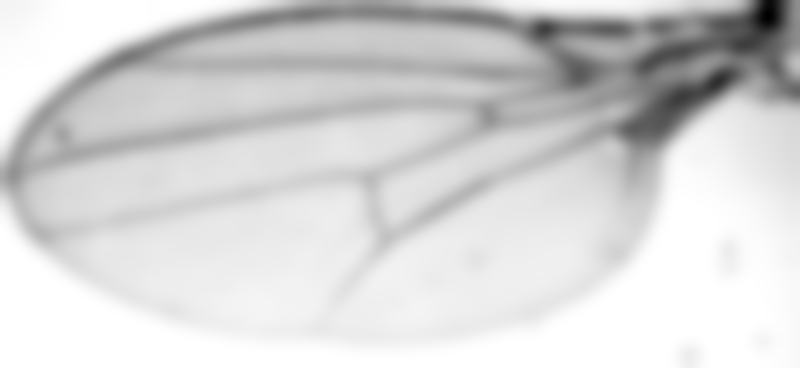

In [2]:
import io.scif.img.ImgOpener
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.algorithm.gauss.Gauss
import net.imglib2.img.Img

// open with ImgOpener as a FloatType
Img<FloatType> image = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif", new
  FloatType()).get(0)

// perform gaussian convolution with float precision
sigma = new double[image.numDimensions()]

for (int d = 0; d < image.numDimensions(); ++d) {
  sigma[d] = 8.0
}

output = Gauss.toFloat(sigma, image)

nb.display(output)

## Example 6a - Gaussian convolution (variation 2 - different OutOfBoundsStrategy)

Here we use an **OutOfBoundsStrategyConstantValue** instead. It results in continuously darker borders as the zero-values from outside of the image are used in the convolution. Note that the computation is done in-place here. However, we still need to provide an [ImgFactory](http://javadoc.imagej.net/ImgLib2/net/imglib2/img/ImgFactory.html) as the Gaussian convolution needs to create temporary image(s) - except for the one-dimensional case.

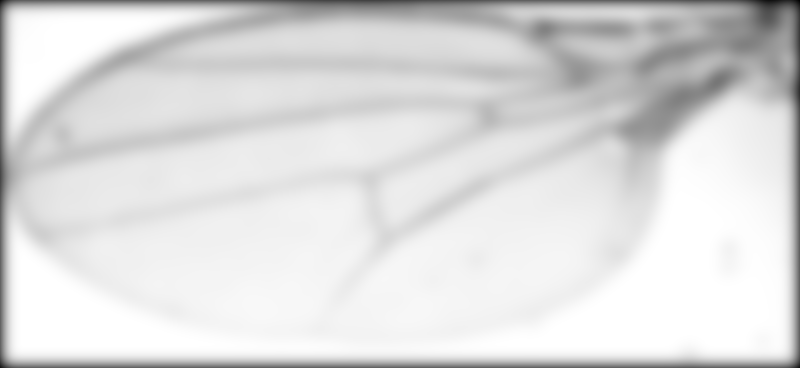

In [3]:
import io.scif.img.ImgOpener
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.view.Views
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.algorithm.gauss3.Gauss3

// open with ImgOpener as a FloatType
image = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif", new FloatType()).get(0)

// first extend the image to infinity, zeropad
infiniteImg = Views.extendValue(image, new FloatType())

// now we convolve the whole image manually in-place
// note that it is basically the same as the call above, just called in a more generic way
//
// sigma .. the sigma
// infiniteImg ... the RandomAccessible that is the source for the convolution
// image ... defines the RandomAccessibleInterval that is the target of the convolution
Gauss3.gauss(sigma, infiniteImg, image);

nb.display(image)

## Example 6a - Gaussian convolution (variation 3 - only part of an Interval)

Here we only convolve part of an [**Interval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html), or in this case part of the [**Img**](http://javadoc.imagej.net/ImgLib2/net/imglib2/img/Img.html). Note that for convolution, it will actually use the real image values outside of the defined [**Interval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html). The **OutOfBoundsStrategy** is only necessary if the kernel is that large so that it will actually grep image values outside of the underlying [**Img**](http://javadoc.imagej.net/ImgLib2/net/imglib2/img/Img.html).

Note: if you wanted, you could force it to use an **OutOfBoundsStrategy** directly outside of the [**Interval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html). For that you would have to create an [**RandomAccessibleInterval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessibleInterval.html) on the [**Img**](http://javadoc.imagej.net/ImgLib2/net/imglib2/img/Img.html), extend it by an **OutOfBoundsStrategy** and give this as input to the Gaussian convolution.

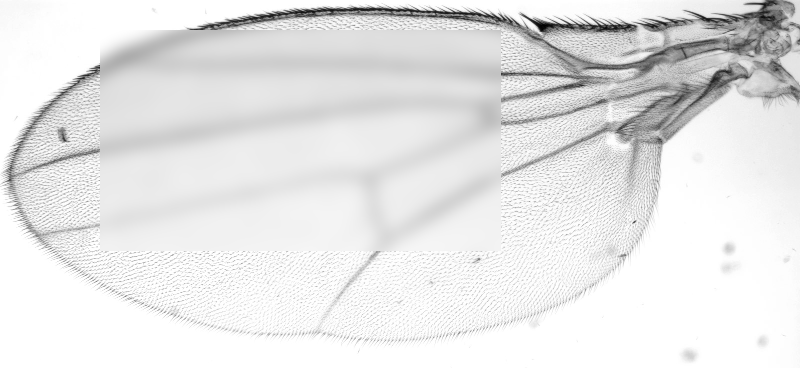

In [4]:
import io.scif.img.ImgOpener
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.view.Views
import net.imglib2.algorithm.gauss3.Gauss3
import net.imglib2.util.Intervals

// open with ImgOpener as a FloatType
image = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif", new FloatType()).get(0)

// we need to extend it nevertheless as the algorithm needs more pixels from around
// the convolved area and we are not sure how much exactly (although we could compute
// it with some effort from the sigma).
// Here we let the Views framework take care of the details. The Gauss convolution
// knows which area of the source image is required, and if the extension is not needed,
// it will operate on the original image with no runtime overhead.
infiniteImg = Views.extendMirrorSingle(image)
 
// define the area of the image which we want to compute
interval = Intervals.createMinMax(100, 30, 500, 250)
region = Views.interval(image, interval)

 // call the gauss, we convolve only a region and write it back to the exact same coordinates
 Gauss3.gauss(sigma, infiniteImg, region)

nb.display(image)

## Example 6a - Gaussian convolution (variation 4 - with a lower dimensionality)

This example shows how to apply an algorithm to a lower dimensionality as the image data you are working on. Therefore we use [View](http://javadoc.imagej.net/ImgLib2/net/imglib2/View.html)s to create HyperSlices which have n-1 dimensions. We simply apply the algorithm in-place on those [View](http://javadoc.imagej.net/ImgLib2/net/imglib2/View.html)s which will automatically update the image data in the higher-dimensional data.

Specifically, we apply 1-dimensional Gaussian convolution in 30-pixel wide stripes using a sigma of 16. Note that whenever you request a HyperSlice for a certain dimension, you will get back a [View](http://javadoc.imagej.net/ImgLib2/net/imglib2/View.html) that contains all dimensions but this one.

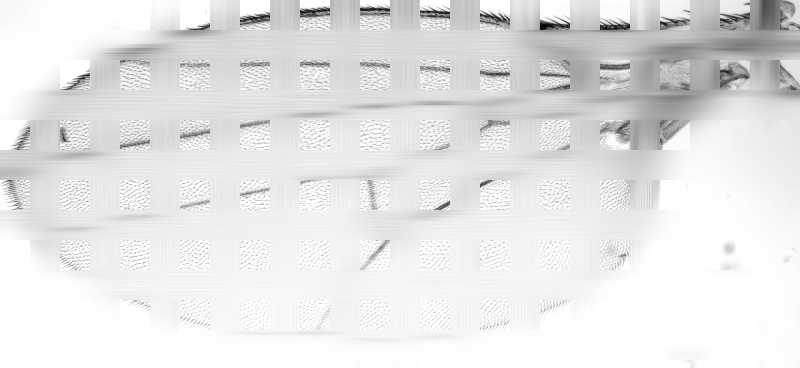

In [5]:
import io.scif.img.ImgOpener
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.view.Views
import net.imglib2.algorithm.gauss3.Gauss3
import net.imglib2.util.Intervals

// open with ImgOpener as a FloatType
image = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif", new FloatType()).get(0)

double[] sigma = new double[image.numDimensions() - 1]

for (int d = 0; d < sigma.length; ++d) {
  sigma[d] = 16.0
}
 
// iterate over all dimensions, take always a hyperslice
for (int dim = 0; dim < image.numDimensions(); ++dim) // iterate over all possible hyperslices
{
  for (long pos = 0; pos < image.dimension(dim); ++pos) // convolve a subset of the 1-dimensional views
  {
    long s = pos / 30
    if (s % 2 == 1) {
      // get the n-1 dimensional "slice"
      view = Views.hyperSlice(image, dim, pos)
      
      // compute the gauss in-place on the view
      Gauss3.gauss(sigma, Views.extendMirrorSingle(view), view)
    }
  }
}

nb.display(image)